In [8]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
from datetime import datetime
from tqdm import tqdm

from IPython.display import Audio
import torchaudio
import librosa

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# from soundbay.utils.metadata_processing import create_wav_info_df, convert_month_annotation_to_file_anotation
from soundbay.utils.metadata_processing import get_wav_info_df, add_month_acc_duration, load_corrected_annotation_df

BASE_PATH = Path(os.getcwd())
DATASET_PATH = BASE_PATH / "datasets/fannie_project"
print(DATASET_PATH)

/mnt/d/DeepVoice/soundbay/datasets/fannie_project


# Use CQT to detect whale calls
might be better tool to find blue whale calls than STFT

In [3]:
wav_info_df = get_wav_info_df(DATASET_PATH)
wav_info_df = add_month_acc_duration(wav_info_df)
wav_info_df.head()

Processing wav files: 100%|██████████| 9276/9276 [00:57<00:00, 160.21it/s]


,wav_file,duration,sample_rate,rec_id,date_time,month_year,accumulated_duration
0,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,840.025500,96000,5756,2021-04-15 18:29:58,4-2021,0.000000
1,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,840.004667,96000,5756,2021-04-15 19:29:58,4-2021,840.025500
2,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,840.008000,1000,5756,2021-04-15 20:29:58,4-2021,1680.030167
3,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,840.022000,1000,5756,2021-04-15 21:29:58,4-2021,2520.038167
4,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,840.023000,1000,5756,2021-04-15 22:29:58,4-2021,3360.060167


In [ ]:
ant_blue_annotation = load_corrected_annotation_df(DATASET_PATH / "ANT_BLUE", wav_info_df)
mad_blue_annotation = load_corrected_annotation_df(DATASET_PATH / "MAD_BLUE", wav_info_df)
ant_blue_annotation.head(3)

In [ ]:
# create a dataframe of all anotations on specific files:
ant_blue_annotation['type'] = 'ANT_BLUE'
mad_blue_annotation['type'] = 'MAD_BLUE'
all_annotations = pd.concat([ant_blue_annotation, mad_blue_annotation])
all_annotations['Selection'] = range(1, len(all_annotations) + 1)
file_df = all_annotations[all_annotations.wav_file == "5756.210505122958.wav"]
file_df

In [ ]:
# Rename columns for the 'file_df' DataFrame
file_df.columns = [
    "Selection", "View", "Channel", "Begin Time (s)", "End Time (s)", 
    "High Freq (Hz)", "Low Freq (Hz)", "Peak Freq (Hz)", "Delta Time (s)", 
    "Dur 90% (s)", "SNR NIST Quick (dB)", "Wav File", "Date Time", 
    "Duration", "Accumulated Duration", "Class Name"
]

# choose columns:
selected_columns = [
    "Selection", "View", "Channel", "Begin Time (s)", "End Time (s)", 
    "High Freq (Hz)", "Low Freq (Hz)", "Peak Freq (Hz)", "Delta Time (s)", 
    "Dur 90% (s)", "SNR NIST Quick (dB)", "Class Name"
]
file_df = file_df[selected_columns]

# file_df.to_csv("../5756.210505122958_original_annotation.csv")
# file_df.to_csv("../5756.210505122958_original_annotation.txt", sep="\t", index=False)


In [5]:
# load annotations into dataframe, they are saved as text file
mad_may_df = pd.read_csv(DATASET_PATH / "MAD_BLUE" / "LF_5756.210501002958.Table.1.selections.txt", sep="\t", on_bad_lines='skip')

In [ ]:
# annotation_df = convert_month_annotation_to_file_anotation(mad_may_df, wav_info_df)
# annotation_df.head()

NameError: name 'convert_month_annotation_to_file_anotation' is not defined

Loaded /mnt/d/DeepVoice/soundbay/datasets/fannie_project/5756.210527102958.wav with sample rate 1000 and waveform shape (840006,)
Resampled waveform shape: (420003,) at sample rate 500


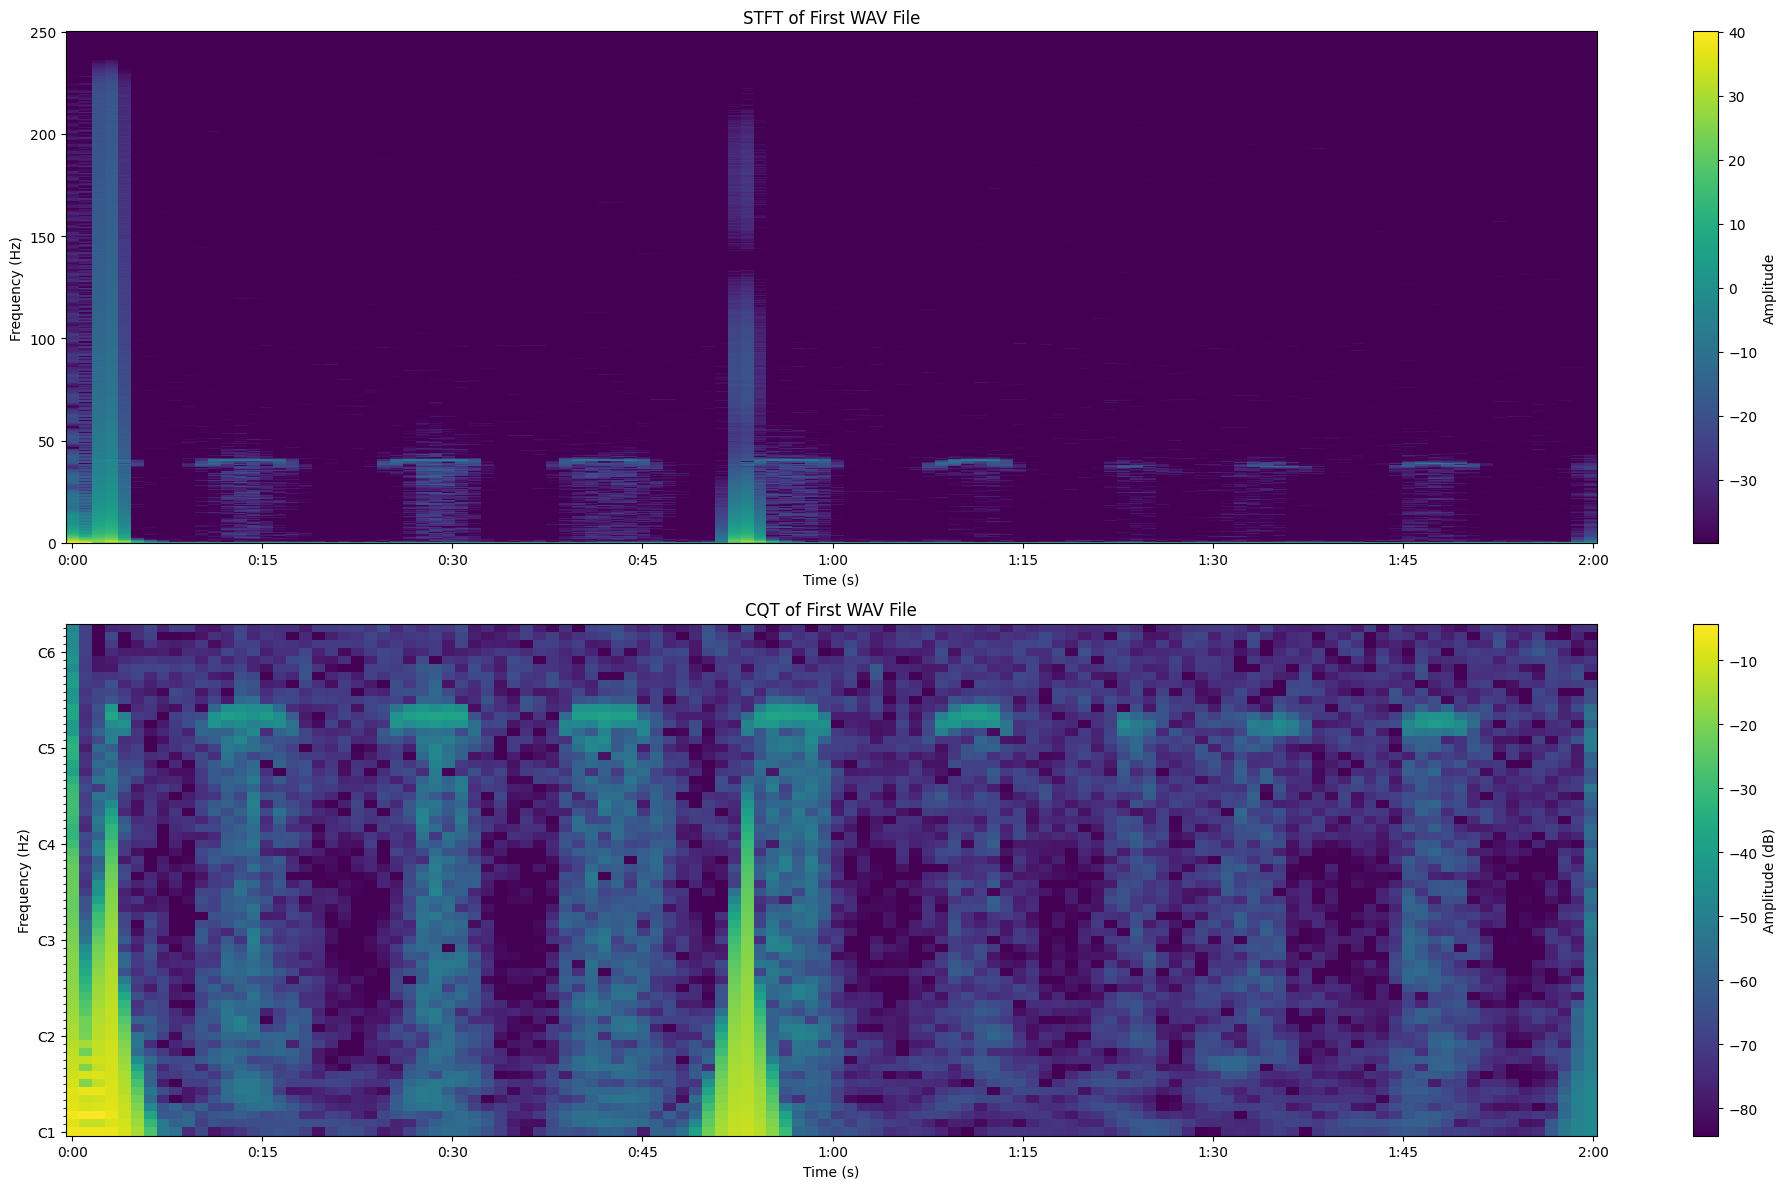

In [40]:
import librosa.display

# Extract the first wav file path
first_wav_file = wav_info_df.iloc[1000]['wav_file']

# Load the audio file
waveform, sample_rate = librosa.load(first_wav_file, sr=None)
print(f"Loaded {first_wav_file} with sample rate {sample_rate} and waveform shape {waveform.shape}")
waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=500)
sample_rate = 500  # Update sample rate after resampling
print(f"Resampled waveform shape: {waveform.shape} at sample rate {sample_rate}")

waveform = waveform[:sample_rate * 120]  # Use only the first 60 seconds for visualization
# Create a single figure with two subplots for STFT and CQT
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# Plot STFT
stft = librosa.stft(waveform, n_fft=2048, hop_length=512)
stft_db = librosa.amplitude_to_db(abs(stft))
librosa.display.specshow(stft_db, sr=sample_rate, x_axis='time', y_axis='linear', cmap='viridis', ax=axs[0])
axs[0].set_title("STFT of First WAV File")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
fig.colorbar(axs[0].collections[0], ax=axs[0], label="Amplitude")

# Compute and plot CQT
cqt = librosa.cqt(waveform, fmin=2.0, bins_per_octave=12, n_bins=64, sr=sample_rate)
cqt_db = librosa.amplitude_to_db(abs(cqt))
librosa.display.specshow(cqt_db, sr=sample_rate, x_axis='time', y_axis='cqt_note', cmap='viridis', ax=axs[1])
axs[1].set_title("CQT of First WAV File")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Frequency (Hz)")
fig.colorbar(axs[1].collections[0], ax=axs[1], label="Amplitude (dB)")

plt.tight_layout()
plt.show()